# Problem Set 2
### Lukas Hager,  ECON 532
___

## Market Simulation
**For each of these two simulations, compare the distribution of prices, profits and consumer surplus. For consumer surplus, simulate draws of consumers from the true distribution and calculate their optimal purchasing decision and welfare**
___
To get prices, we simply squeeze the variable `P_opt` to be one dimensional and plot a histogram. To get profit and consumer surplus, we must simulate customers; given the simulation variable `alphas`, we take this number to be 500. Then, we calculate 
$$\pi_{jm} = \text{Market Share} \times \text{Consumers} \times \left(p_{jm} - mc_{jm}\right)$$
and
$$CS_{im} = \frac{1}{\alpha_{i}}\max_{j}U_{ijm}$$

In [1]:
# import libraries
import numpy as np
import numpy.random as rand
import pandas as pd
import scipy as sp
from scipy import optimize as op
from scipy.io import loadmat
from sklearn import linear_model as lm
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,5)

source_path = '/Users/hlukas/git/uw_grad_school_code/ECON-532/Assignment 2/pset2_upload/Simulated Data/{}markets{}products.mat'
gamma = np.array([2,1,1]).reshape(3,1)
alpha = 1.
sigma_alpha = 1.
beta = np.array([5.,1.,1.]).reshape((3,1))

In [2]:
# function to import the data into python

def import_data(mkts,prods):
    mat_data = loadmat(source_path.format(mkts,prods))
    variable_names = [x for x in mat_data.keys() if x not in ['__header__', '__version__', '__globals__']]
    return([mat_data[x] for x in variable_names])

In [3]:
# function to plot prices

def plot_prices(mkts, prods):
    # import data
    x1,xi_all,w,eta,Z,alphas,P_opt,shares = import_data(mkts,prods)
    
    p_flat = P_opt.reshape(prods * mkts)
    plt.hist(p_flat, bins=int(np.ceil(p_flat.max() - np.min([0., np.min(p_flat)]))*2), ec='black', range=(np.floor(np.min([0., np.min(p_flat)])), np.ceil(p_flat.max())))
    plt.title('Price Distribution ({} Products, {} Markets)'.format(prods, mkts))
    plt.xlabel('Price')
    plt.ylabel('Products')
    plt.show()

In [4]:
# function to plot profits

def plot_profit(mkts, prods):
    # import data
    x1,xi_all,w,eta,Z,alphas,P_opt,shares = import_data(mkts,prods)
    
    # get consumers
    n_consumers = alphas.shape[1]
    
    # get the marginal cost
    mc_jm = np.column_stack([np.ones(prods * mkts),w, Z]) @ gamma + eta
    markup = P_opt.T - mc_jm.reshape((mkts, prods))

    profit = markup * shares.T * n_consumers
    
    profit_flat = profit.reshape(prods * mkts)
    plt.hist(profit_flat, bins='fd', ec = 'black')
    plt.title('Profit Distribution ({} Products, {} Markets, {} Consumers)'.format(prods, mkts, n_consumers))
    plt.xlabel('Profit')
    plt.ylabel('Products')

The way that we calculate consumer surplus requires a little more explication. We know that
$$U_{ijm} = X_{jm}\beta - p_{jm}\alpha_i + \xi_{jm} + \epsilon_{ijm}$$
We can instead write utility as a $im\times j$ matrix, so that each row represents a consumer/market combination, and each column is a given product. We can do this by getting the utility that doesn't depend on the consumer, stacking that matrix $i$ times, stacking the price and $\xi$ matrix $i$ times, and creating an $\alpha$ matrix by repeating each $\alpha_i$ $j$ times:

In [5]:
def plot_cs(mkts, prods):
    # set a seed
    rand.seed(seed=2022)
    
    # import data
    x1,xi_all,w,eta,Z,alphas,P_opt,shares = import_data(mkts,prods)
    
    # get consumers
    n_consumers = alphas.shape[1]

    # get the alpha_i, reshape to be in the order first market -> last market 500 times
    alpha_i = alphas.reshape((n_consumers * mkts,1), order = 'F')

    # repeat the alpha_i for each market
    alpha_big = np.tile(alpha_i, (1,prods))

    # get the market-product level utility
    u_jm = (x1 @ beta + xi_all).reshape((mkts,prods))

    # create a big system
    u_big = np.tile(u_jm, (n_consumers,1))
    p_big = np.tile(P_opt.T, (n_consumers,1))
    ep_big = rand.gumbel(size = mkts * prods * n_consumers).reshape((mkts * n_consumers, prods))

    # get the CS
    u = u_big - alpha_big * p_big + ep_big
    u_outside = np.concatenate([u, np.zeros(mkts * n_consumers).reshape((mkts * n_consumers, 1))], axis = 1)
    cs = u_outside.max(axis = 1) / alpha_i.squeeze()
    cs_mean = np.mean(cs.reshape((100,500), order = 'F'), axis = 1)
    
    # plot
    plt.hist(cs_mean.squeeze(), bins=int(np.ceil(cs_mean.max() - np.min([0., np.min(cs_mean)]))*2), ec='black', range=(np.min([0., np.min(cs_mean)]), np.ceil(np.max(cs_mean))))
    plt.title('CS Distribution ({} Products, {} Markets, {} Consumers)'.format(prods, mkts, n_consumers))
    plt.xlabel('Surplus')
    plt.ylabel('Markets')
    plt.show()

In [447]:
def plot_cs(mkts, prods):
    # import data
    x1,xi_all,w,eta,Z,alphas,P_opt,shares = import_data(mkts,prods)
    
    # get consumers
    n_consumers = alphas.shape[1]

    # get the alpha_i
    alpha_i = alphas.reshape(-1,1) - 1.

    # get the market-product mean utility
    u_jm = (x1 @ beta + xi_all - P_opt.T.reshape(-1,1)).reshape(mkts, prods)

    # create a big system
    u_big = np.repeat(u_jm, n_consumers, axis = 0)
    p_big = np.repeat(P_opt.T, n_consumers, axis = 0)

    # get the CS
    u = u_big - alpha_i * p_big
    #u_outside = np.concatenate([u, np.zeros(mkts * n_consumers).reshape((mkts * n_consumers, 1))], axis = 1)
    cs = (.5772 + np.log(np.sum(np.exp(u), axis = 1))) / alpha_i.squeeze()
    cs_mean = np.mean(cs.reshape(100,500).clip(0), axis = 1)
    
    # plot
    plt.hist(cs_mean.squeeze(), bins=int(np.ceil(cs_mean.max() - np.min([0., np.min(cs_mean)]))), ec='black', range=(np.min([0., np.min(cs_mean)]), np.ceil(np.max(cs_mean))))
    plt.title('CS Distribution ({} Products, {} Markets, {} Consumers)'.format(prods, mkts, n_consumers))
    plt.xlabel('Surplus')
    plt.ylabel('Markets')
    plt.show()

#### Price Plots
___

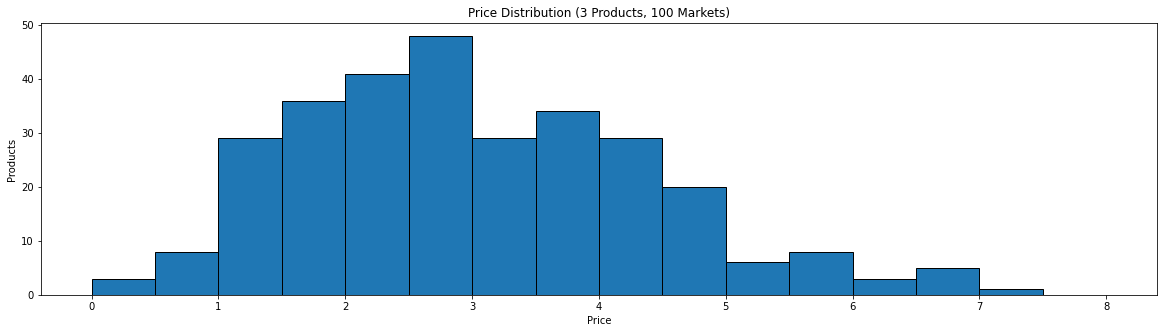

In [448]:
plot_prices(100,3)

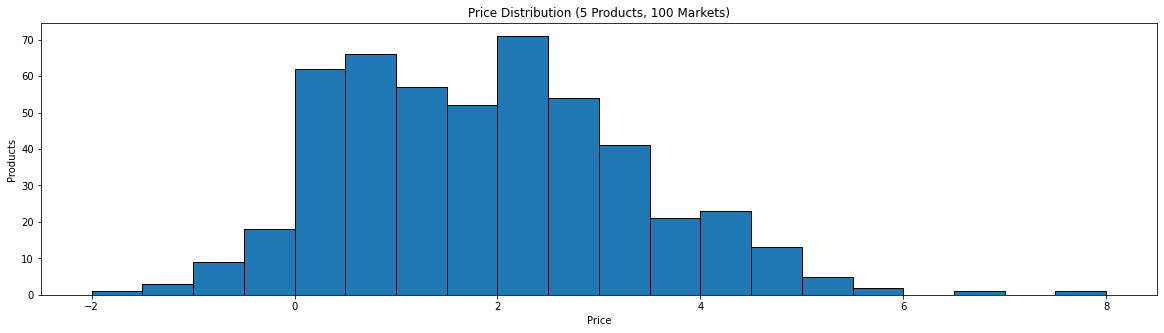

In [449]:
plot_prices(100,5)

Prices appear to be higher in the 3 good market compared to the 5 good market; this makes sense, as in a competitive market, more competition should drive down the prices that firms can charge.

#### Profit Plots
___

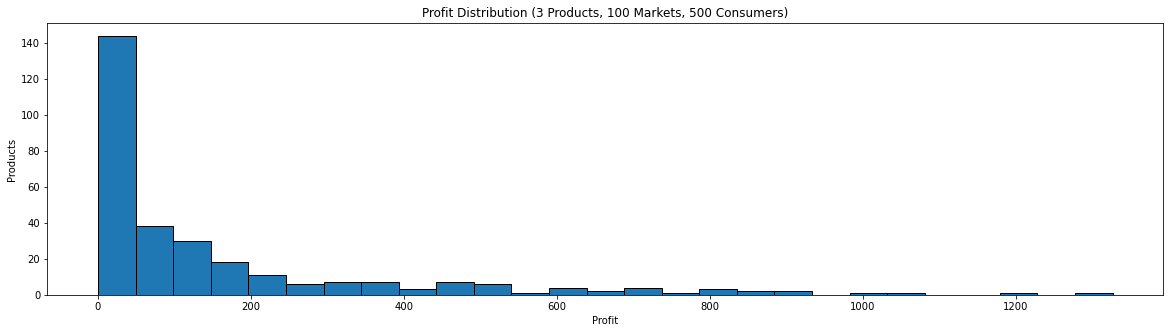

In [8]:
plot_profit(100,3)

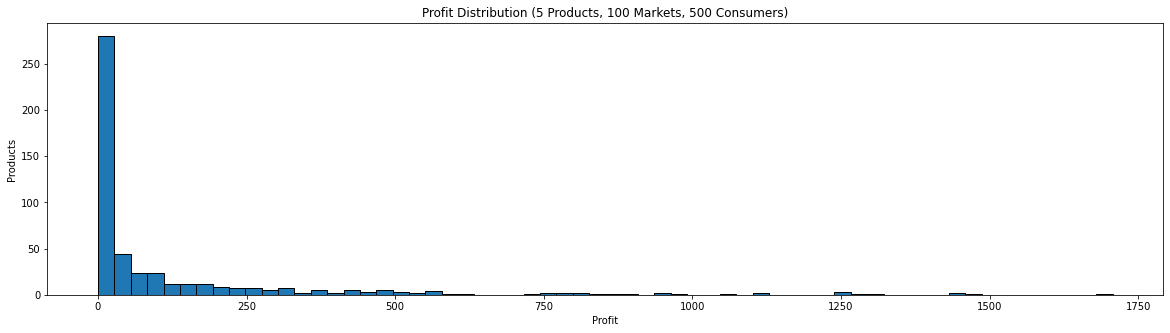

In [9]:
plot_profit(100,5)

The takeaway is similar to the above; when there is more competition, the profits of firms decrease, and the distribution is shifted towards lower amounts of profit.

#### Consumer Surplus Plots
___

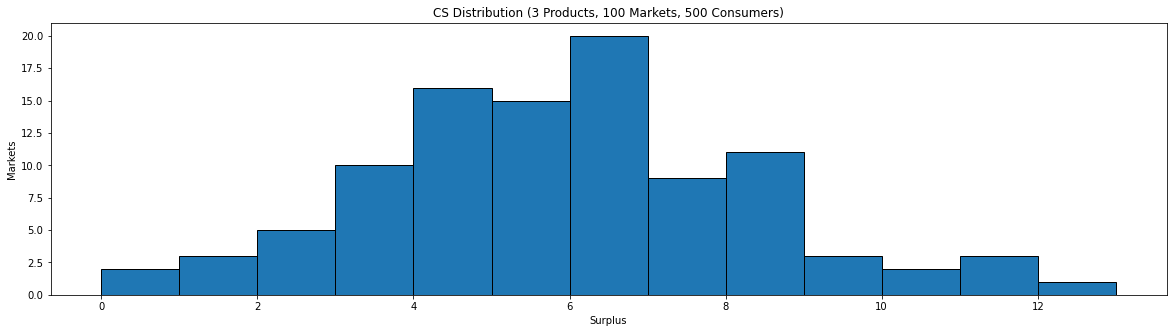

In [450]:
plot_cs(100,3)

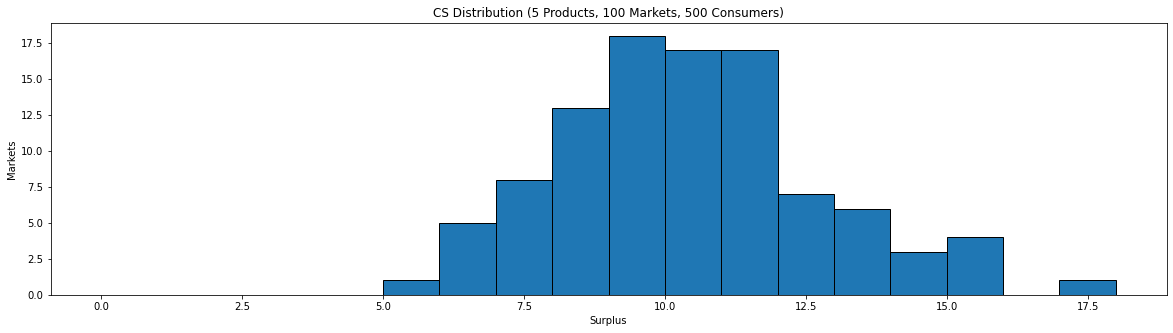

In [451]:
plot_cs(100,5)

Here, we see a large difference. In both simulations, a modal number of customers choose the outside option, but when there are more options, the consumer surplus increases significantly.

## BLP and Nevo Instruments
___

In [12]:
# import data
x1,xi_all,w,eta,Z,alphas,P_opt,shares = import_data(100,3)

# xi/X
xi_X = np.mean(x1 * np.tile(xi_all, (1,3)), axis = 0)

# xi/p
xi_p = np.mean(P_opt.T * xi_all.reshape((100,3)))

# xi/p_hat
# to get p_hat, we compute average prices across other markets
p_hat = np.tile(
    np.array([np.mean(np.delete(P_opt.T,x,0)) for x in range(len(P_opt.T))]).reshape((100,1)),
    (1,3)
)

p_hat = np.row_stack([np.mean(np.delete(P_opt.T,x,0), axis = 0) for x in range(len(P_opt.T))])

xi_p_hat = np.mean(p_hat * xi_all.reshape((100,3)))

In [13]:
xi_X

array([0.04346104, 0.02074192, 0.0355315 ])

In [14]:
xi_p

0.2949581371489729

In [15]:
xi_p_hat

0.14367954767468022

It appears that $\mathbb{E}[\xi_{jm}X_{jm}] \approx 0$ and $\mathbb{E}[\xi_{jm}\overline{p}_{jm}] \approx 0$, so these conditions are likely roughly valid. Additionally, using $p$ appears to be irrelevant if we use $\overline{p}$.

We cannot use BLP and Nevo instruments in this setting, as Nevo uses a dummy variable for brand (firm in our case), which means that the BLP instruments do not have any variance within a given firm. 

Our estimation algorithm will work as follows:
1. Fix $\hat{\sigma}_{\alpha}$
2. Using this parameters and the simulated consumers, get
   $$\hat{s}_n \approx \frac{1}{n}\sum_{i=1}^{500}\frac{e^{\delta_j + \mu_{ij}}}{1 + \sum_se^{\delta_s + \mu_{is}}}$$
   Further, in our case, we have
   $$\delta_{jm} = X_{jm}\hat{\beta} - \hat{\alpha}p_{jm} + \xi_{jm}$$
   and 
   $$\mu_{ij} = -\hat{\sigma}_{\alpha}\nu_ip_{jm}$$
   We solve the fixed point problem via iteration to get the values of $\delta_{jm}$ which result in $\hat{s}_n = s_n$.
3. Noting that
   $$\delta_{jm} = X_{jm}\beta - \alpha p_{jm} + \xi_{jm}$$
   run an IV regression on the estimated $\delta_{jm}$ to estimate $\hat{\xi}_{jm},\hat{\alpha}_{jm},\hat{\beta}_{jm}$.
4. Calculate the GMM objective function using instruments and $\hat{\xi}_{jm}$. When the objective function is minimized, return $\hat{\alpha}, \hat{\beta}, \hat{\sigma}_{\alpha}$.

The GMM objective function will be calculated using BLP-style demand moments. In particular, we will have instruments given by
$$Z_j = \left[X_j,\sum_{r\neq j, r\in \mathcal{F}_j}X_r,\sum_{r\notin \mathcal{F}_j}X_r\right]$$
Informally, instruments are the product's own characteristics, the sum of other products' characteristics within a product's market, and the sum of all products characteristics in other markets. As each firm is a single-product firm, we cannot use other products' characteristics, and as one of our instrument is a constant, we cannot use a function of this constant for colinearity reasons. This implies that in our problem we will have five instruments, and $Z$ is a $5\times 1$ vector. Then, the GMM criterion function is given by
$$\hat{\theta} = \text{arg min}_{\theta}\hat{\xi}^{\top}ZWZ'\hat{\xi}$$
where $W$ is given by
$$W = \left(Z^{\top}Z\right)^{-1}$$

In [17]:
def get_shares(mkts,prods,n_consumers,price_val,delta,sigma,nu_vals):
    u_big = np.repeat(delta, n_consumers, axis = 0)
    p_big = np.repeat(price_val, n_consumers, axis = 0)
    u_indiv = u_big - sigma * p_big * nu_vals
    u_exp = np.exp(u_indiv)
    denom = (1. + np.sum(u_exp, axis = 1)).reshape(-1,1)
    s_indiv = u_exp / denom
    shares_list = [np.mean(s_indiv[(i*n_consumers):((i+1)*n_consumers)], axis = 0) for i in range(mkts)]
    return(np.row_stack(shares_list))

In [18]:
def calculate_theta1(delta,X,p,Z):
    # stack data
    big_X = np.column_stack([X, p.T.reshape(-1,1)])
    
    # projection matrix
    P_Z = Z @ np.linalg.inv(Z.T @ Z) @ Z.T
    
    return(np.linalg.inv(big_X.T @ P_Z @ big_X) @ big_X.T @ P_Z @ delta.reshape(-1,1))

In [19]:
def get_xi_hat(delta,X,p,Z):
    t1_hat = calculate_theta1(delta,X,p,Z)
    return(delta.reshape(-1,1) - np.column_stack([X, p.T.reshape(-1,1)]) @ t1_hat)

In [20]:
def get_demand_instruments(X,prods,mkts):
    z1 = X # own characteristics
    
    z2_list = [np.sum(z1[:,1:][(i*prods):((i+1)*prods)], axis = 0) for i in range(int(X.shape[0]/prods))]
    z2 = np.repeat(np.row_stack(z2_list), prods, axis = 0) - z1[:,1:] # sum characteristics for the firm's products, subtract z1
        
    return(np.column_stack([z1,z2]))

In [255]:
def get_delta(sigma,nu_i):
    # set initial delta guess
    delta_new = np.ones(mkts * prods).reshape(mkts,prods)
    delta_old = np.ones(mkts * prods).reshape(mkts,prods)

    # iterate (as it's a contraction mapping)
    while True:
        s_calc = get_shares(mkts,prods,n_consumers,P_opt.T,delta_old,sigma,nu_i)
        delta_new = delta_old + np.log(shares.T) - np.log(s_calc)
        crit = np.max(np.abs(delta_new - delta_old))
        if crit > 1e-3:
            delta_old = delta_new
        else:
            break
            
    return(delta_new)

In [202]:
def gmm_obj(sigma, Z, nu_i_val):
    
    delta_new = get_delta(sigma,nu_i_val)
    
    theta1 = calculate_theta1(delta_new,x1,P_opt,Z)

    xi_hat = get_xi_hat(delta_new,x1,P_opt,Z)
    W = np.linalg.inv(Z.T @ Z)
    return((xi_hat.T @ Z @ W @ Z.T @ xi_hat).item())

In [23]:
def gmm_min(start_val, Z_val, nu_i_val):
    return(
        op.minimize(
            gmm_obj, 
            x0 = start_val, 
            args = (Z_val, nu_i_val), 
            #method='Nelder-Mead',
            options = {'disp': True}
        )
    )

In [440]:
def plot_estimated_cs(mkts, prods, t2):
    # set a seed
    rand.seed(seed=900)
    
    # import data
    x1,xi_all,w,eta,Z,alphas,P_opt,shares = import_data(mkts,prods)
    
    # get consumers
    n_consumers = alphas.shape[1]

    # get the alpha_i
    nu_i = rand.lognormal(size = n_consumers * mkts).reshape(-1,1)
    alpha_i = t2 * nu_i

    # get the market-product mean utility
    u_jm = get_delta(t2, nu_i)

    # create a big system
    u_big = np.repeat(u_jm, n_consumers, axis = 0)
    p_big = np.repeat(P_opt.T, n_consumers, axis = 0)

    # get the CS
    u = u_big - alpha_i * p_big
    #u_outside = np.concatenate([u, np.zeros(mkts * n_consumers).reshape((mkts * n_consumers, 1))], axis = 1)
    cs = (.5772 + np.log(np.sum(np.exp(u), axis = 1))) / alpha_i.squeeze()
    cs_mean = np.mean(cs.reshape(100,500).clip(0), axis = 1)
    
    # plot
    plt.hist(cs_mean.squeeze(), bins=int(np.ceil(cs_mean.max() - np.min([0., np.min(cs_mean)]))), ec='black', range=(np.min([0., np.min(cs_mean)]), np.ceil(np.max(cs_mean))))
    plt.title('CS Distribution ({} Products, {} Markets, {} Consumers)'.format(prods, mkts, n_consumers))
    plt.xlabel('Surplus')
    plt.ylabel('Markets')
    plt.show()

In [196]:
def get_elasticities(mkts,prods,n_consumers,sigma,alpha,price_vals,nu_i_vals):
    # get implied delta and shares
    delta = get_delta(sigma, nu_i_vals)
    share_vals = get_shares(mkts,prods,n_consumers,price_vals.T,delta,sigma,nu_i_vals)
    
    # get individual shares
    u_exp = np.exp(np.repeat(delta, n_consumers, axis = 0) - sigma * np.repeat(price_vals.T, n_consumers, axis = 0) * nu_i_vals.reshape(-1,1))
    sum_terms = 1. + np.sum(u_exp, axis = 1).reshape(-1,1)
    indiv_shares = (u_exp / sum_terms)
    
    # convert to 300x3 matrix, where each 3x3 matrix yields all elasticities for a given market
    
    indiv_mkts_x_shares = [indiv_shares[i].reshape(-1,1) @ indiv_shares[i].reshape(1,-1) for i in range(len(indiv_shares))]
    cross_shares_matrix = np.concatenate(indiv_mkts_x_shares, axis = 0)
    own_shares_ind = np.repeat(indiv_shares, prods, axis = 0) * np.tile(np.eye(prods), (n_consumers * mkts,1))
    
    # get the derivative terms
    d_terms = np.repeat(alpha + sigma * nu_i_vals.reshape(-1,1), 3, axis = 0)

    total_mat = d_terms * (cross_shares_matrix - own_shares_ind)
    
    all_blocks = []
    for i in range(100):    
        mkt_blocks = [total_mat[j:(j+prods)] for j in range(i * prods * n_consumers, (i+1) * prods * n_consumers, prods)]
        all_blocks.append(np.mean(mkt_blocks, axis = 0))

    all_elasticities = np.concatenate(all_blocks, axis = 0) * price_vals.T.reshape(-1,1) / np.repeat(share_vals,prods,axis = 0)
    
    return(all_elasticities)

In [ ]:
def plot_estimated_profit(mkts,prods,n_consumers,sigma,alpha,price_vals,nu_i_vals):
    
    # get the elasticities
    elas = get_elasticities(mkts,prods,n_consumers,sigma,alpha,price_vals,nu_i_vals)
    
    # create delta under given (one firm, one product)
    Delta = sp.linalg.block_diag([elas[(i*prods):((i+1) * prods)] for i in range(mkts)])

In [474]:
elas = get_elasticities(100,3,500,1.,1.,P_opt,alphas.reshape(-1,1)-1.)
Delta = sp.linalg.block_diag(*[elas[(i*prods):((i+1) * prods)] for i in range(mkts)]) * np.eye(300)
s_hat = get_shares(100,3,500,P_opt.T,get_delta(1.,alphas.reshape(-1,1)-1.),1.,alphas.reshape(-1,1)-1.)
markup = np.linalg.inv(Delta) @ s_hat.reshape(-1,1)
#[elas[(i*prods):((i+1) * prods)] for i in range(mkts)]

In [475]:
markup

array([[-6.13079267e-06],
       [-8.24457472e-01],
       [-3.13164801e-02],
       [-2.68426690e-02],
       [-5.75419917e-02],
       [-8.99675402e-01],
       [-5.79431592e-02],
       [-4.94332759e-02],
       [-9.71171099e-01],
       [-8.71404148e-04],
       [-5.36420097e-01],
       [-3.16642425e-02],
       [-8.03830085e-03],
       [-2.60450222e-01],
       [-1.01081663e-01],
       [-1.88131144e-02],
       [-4.56395986e-02],
       [-1.55464405e-02],
       [-7.85965724e-02],
       [-2.67595343e-02],
       [-7.45098933e-03],
       [-4.86931938e-05],
       [-1.20044835e+00],
       [-2.87147119e-03],
       [-9.06544128e-05],
       [-1.54891996e+00],
       [-8.06843273e-02],
       [-2.95635773e-04],
       [-6.74383994e-01],
       [-2.34315715e-03],
       [-1.72217658e-02],
       [-3.46715643e-01],
       [-4.97484650e-03],
       [-6.41336290e-03],
       [-3.47996083e-01],
       [-2.82928629e-02],
       [-1.48469908e-04],
       [-5.35287909e-01],
       [-2.1

In [470]:
Delta[:6]

array([[-8.46216171e+00,  4.98683734e-04,  6.48924406e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.10200072e+00, -8.71412836e-01,  2.90656393e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.60146631e-01,  5.95223190e-01, -3.82389894e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [257]:
mkts = 100
prods = 3

# set a seed
rand.seed(seed=900)

# import data
x1,xi_all,w,eta,Z,alphas,P_opt,shares = import_data(mkts,prods)

# get number of consumers
n_consumers = alphas.shape[1]

# simulate consumers
nu_i_fixed = rand.lognormal(size = n_consumers * mkts).reshape(-1,1)

# get instruments

demand_Z = get_demand_instruments(x1, prods, mkts)

# optimize GMM for different values

results_dict = {x: gmm_min(x, Z, nu_i_fixed) for x in np.arange(1.,10.,1.)}

In [245]:
{x: results_dict[x]['x'].item() for x in results_dict.keys()}

{1.0: 1.1900916733692875,
 2.0: 1.1901104521408437,
 3.0: 1.190111478862404,
 4.0: 1.1901080642558537,
 5.0: 1.1901088746089905,
 6.0: 1.19008676433187,
 7.0: 1.1901078609167173,
 8.0: 1.1901072565451791,
 9.0: 1.1901112768988726}

We can see that regardless of the starting value, we converge to roughly the same value of $\sigma_{\alpha}$. If we plug these into our formula, we get essentially identical parameter estimates for $\hat{\beta},\hat{\alpha}$:

In [275]:
pd.DataFrame(data = {str(s_val): calculate_theta1(get_delta(results_dict[s_val]['x'], nu_i_fixed),x1,P_opt,demand_Z).squeeze() for s_val in results_dict.keys()},
             index = ['b1', 'b2', 'b3', 'a'])



,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
b1,6.699743,6.699906,6.699915,6.699885,6.699892,6.699700,6.699884,6.699878,6.699913
b2,1.309165,1.309197,1.309199,1.309193,1.309194,1.309156,1.309193,1.309192,1.309198
b3,1.156545,1.156557,1.156557,1.156555,1.156556,1.156542,1.156555,1.156555,1.156557
b4,-1.377783,-1.377821,-1.377823,-1.377816,-1.377818,-1.377773,-1.377816,-1.377815,-1.377823


To get SEs, we recall that
$$\hat{\xi} = \delta_{jm} - X_{jm}\hat{\beta} +p_{jm}\hat{\alpha}$$
so then
$$\frac{\partial G_J(\alpha,\beta,\sigma_{\alpha})}{\partial \beta} = -X^{\top}Z$$
and
$$\frac{\partial G_J(\alpha,\beta,\sigma_{\alpha})}{\partial \alpha} = P^{\top}Z$$
The nonlinear parameter $\sigma_{\alpha}$, however, impacts $\delta$. By the chain rule (very informally), for a given market, we know that
$$\frac{\partial \delta}{\partial \sigma_{\alpha}} = \frac{d \delta}{d s}\frac{d s}{d\sigma_{\alpha}}$$
We have
$$\frac{\partial s_j}{\partial \sigma_{\alpha}} = \frac{1}{500}\sum_{i=1}^{500}\frac{\left(1 + \sum_{k=1}^3\exp(\delta_k - \sigma_{\alpha}\nu_ip_k)\right)\exp(\delta_j - \sigma_{\alpha}\nu_ip_j)(-\nu_ip_j)-\exp(\delta_j - \sigma_{\alpha}\nu_ip_j)\sum_{k=1}^3(-\nu_ip_k)\exp(\delta_k - \sigma_{\alpha}\nu_ip_k)}{\left(1 + \sum_{k=1}^3\exp(\delta_k - \sigma_{\alpha}\nu_ip_k)\right)^2}$$
Simplifying yields
$$\frac{\partial s_j}{\partial \sigma_{\alpha}} = -\frac{1}{500}\sum_{i=1}^{500}s_j\nu_i\left[p_j-\sum_{k=1}^3s_kp_k\right]$$
Finally, we know that (shown more formally in the elasticity section below)
$$\frac{\partial s_j}{\partial \delta_j} = \frac{1}{500}\sum_{i=1}^{500}s_{ij} - s_{ij}^2$$
$$\frac{\partial s_j}{\partial \delta_k} = -\frac{1}{500}\sum_{i=1}^{500}s_{ij}s_{ik}$$

Denoting this gradient vector by $\nabla_{\sigma_{\alpha}}$, we then have
$$\frac{\partial G_J(\alpha,\beta,\sigma_{\alpha})}{\partial \sigma_{\alpha}} = \nabla_{\sigma_{\alpha}}^{\top}Z$$
Stacking these will yield the $5\times 5$ $\Gamma$ matrix.

We know that at the optimum of our GMM criterion, the Jacobian value is
$$J = \frac{\partial}{\partial \sigma_{\alpha}}\left(\hat{\xi}^{\top} Z \left(Z^{\top}Z\right)^{-1} Z^{\top}\hat{\xi}\right)$$
This means that
$$J = 2 $$

In [397]:
def v_cov(prods, mkts, n_consumers, sigma, Z, X, P, nu_i_vals):
    # get implied delta and shares
    delta = get_delta(sigma, nu_i_vals)
    share_vals = get_shares(mkts,prods,n_consumers,P.T,delta,sigma,nu_i_vals)

    # get individual shares
    u_exp = np.exp(np.repeat(delta, n_consumers, axis = 0) - sigma * np.repeat(P.T, n_consumers, axis = 0) * nu_i_vals.reshape(-1,1))
    sum_terms = 1. + np.sum(u_exp, axis = 1).reshape(-1,1)
    indiv_shares = (u_exp / sum_terms)

    indiv_mkts_x_shares = [indiv_shares[i].reshape(-1,1) @ indiv_shares[i].reshape(1,-1) for i in range(len(indiv_shares))]
    cross_shares_matrix = np.concatenate(indiv_mkts_x_shares, axis = 0)
    own_shares_ind = np.repeat(indiv_shares, prods, axis = 0) * np.tile(np.eye(prods), (n_consumers * mkts,1))
    total_mat = own_shares_ind - cross_shares_matrix

    # get the inverse matrices
    inv_derivatives = []
    for i in range(100):    
        mkt_blocks = [total_mat[j:(j+prods)] for j in range(i * prods * n_consumers, (i+1) * prods * n_consumers, prods)]
        inv_derivatives.append(np.linalg.inv(np.mean(mkt_blocks, axis = 0)))

    # get the ds/dsigma derivatives and get the product
    row_sums = np.sum(np.repeat(P.T, n_consumers, axis = 0) * indiv_shares, axis = 1)
    diff_terms = np.repeat(P.T, n_consumers, axis = 0) - row_sums.reshape(-1,1)
    prod_terms = -1. * indiv_shares * nu_i_vals * diff_terms

    ds_dsigma = [np.mean(prod_terms[(i * 500):((i+1) * 500)], axis = 0).reshape(-1,1) for i in range(mkts)]
    ddelta_dsigma = np.concatenate([inv_derivatives[i] @ ds_dsigma[i] for i in range(mkts)])
    
    # get the derivatives
    d_beta = -X.T @ Z
    d_alpha = P.T.reshape(-1,1).T @ Z
    d_sigma = ddelta_dsigma.T @ Z
    
    # get total obs
    n = prods * mkts
    
    # create gamma matrix by stacking the individual conditions
    G = np.row_stack([d_beta,d_alpha,d_sigma]) / n
    G_term = np.linalg.inv(G.T @ G) @ G.T
    
    # get V1 by getting the variance of the Z * xi terms
    xi_hat = get_xi_hat(get_delta(sigma, nu_i_vals), X, P, Z)
    Z_e = Z * xi_hat
    V1 = Z_e.T @ Z_e / n
    
    # get V3 by getting the empirical variance from drawing nu 100 times
#     ns_sims = []
#     s = 100
#     for i in range(s):
#         nu_i = rand.lognormal(size = n_consumers * mkts).reshape(-1,1)
#         xi_hat = get_xi_hat(get_delta(sigma, nu_i), X, P, Z)
#         Z_xi = Z * xi_hat
#         ns_sims.append(Z_xi.T @ Z_xi)
        
#     V3 = np.mean(ns_sims, axis = 0)
    
    #return(G_term @ (V1 + V3) @ G_term.T)
    return(G_term @ V1 @ G_term.T)

In [388]:
# params
mkts = 100
prods = 3
n_consumers = 500
price_vals = P_opt
sigma = sigma_hat
nu_i_vals = nu_i_fixed

# get implied delta and shares
delta = get_delta(sigma, nu_i_vals)
share_vals = get_shares(mkts,prods,n_consumers,price_vals.T,delta,sigma,nu_i_vals)

# get individual shares
u_exp = np.exp(np.repeat(delta, n_consumers, axis = 0) - sigma * np.repeat(price_vals.T, n_consumers, axis = 0) * nu_i_vals.reshape(-1,1))
sum_terms = 1. + np.sum(u_exp, axis = 1).reshape(-1,1)
indiv_shares = (u_exp / sum_terms)

indiv_mkts_x_shares = [indiv_shares[i].reshape(-1,1) @ indiv_shares[i].reshape(1,-1) for i in range(len(indiv_shares))]
cross_shares_matrix = np.concatenate(indiv_mkts_x_shares, axis = 0)
own_shares_ind = np.repeat(indiv_shares, prods, axis = 0) * np.tile(np.eye(prods), (n_consumers * mkts,1))
total_mat = own_shares_ind - cross_shares_matrix

# get the inverse matrices
inv_derivatives = []
for i in range(100):    
    mkt_blocks = [total_mat[j:(j+prods)] for j in range(i * prods * n_consumers, (i+1) * prods * n_consumers, prods)]
    inv_derivatives.append(np.linalg.inv(np.mean(mkt_blocks, axis = 0)))

# get the ds/dsigma derivatives and get the product
row_sums = np.sum(np.repeat(price_vals.T, n_consumers, axis = 0) * indiv_shares, axis = 1)
diff_terms = np.repeat(price_vals.T, n_consumers, axis = 0) - row_sums.reshape(-1,1)
prod_terms = -1. * indiv_shares * nu_i_vals * diff_terms

ds_dsigma = [np.mean(prod_terms[(i * 500):((i+1) * 500)], axis = 0).reshape(-1,1) for i in range(mkts)]
ddelta_dsigma = np.concatenate([inv_derivatives[i] @ ds_dsigma[i] for i in range(mkts)])
d_beta = -x1.T @ demand_Z
d_alpha = P_opt.T.reshape(-1,1).T @ demand_Z
d_sigma = ddelta_dsigma.T @ demand_Z

Gamma = np.row_stack([d_beta,d_alpha,d_sigma]) / 300

# get V1 by getting the variance of the Z * xi terms
xi_hat = get_xi_hat(get_delta(sigma, nu_i_vals), x1, P_opt, demand_Z)
Z_e = demand_Z * xi_hat
V1 = Z_e.T @ Z_e / 300

To get elasticity, we need to do some calculations. We know that the cross-price (or same-price, if $j=k$) elasticity is given by
$$\varepsilon_{jk} = \frac{\partial s_j/s_j}{\partial p_k/p_k} = \frac{\partial s_j}{\partial p_k}\frac{p_k}{s_j}$$

Given our shares formulation, we have
$$\frac{\partial s_j}{\partial p_j} = \frac{1}{n}\sum_{i=1}^{500}\frac{(1+\sum_s{\exp(\delta_s + \mu_{is})})(-\alpha-\sigma_{\alpha}\nu_i)\exp(\delta_j + \mu_{ij}) + (\alpha + \sigma_{\alpha}\nu_i)(\exp(\delta_j + \mu_{ij}))^2}{(1+\sum_s{\exp(\delta_s + \mu_{is})})^2}$$
Simplifying yields
$$\frac{\partial s_j}{\partial p_j} = \frac{1}{500}\sum_{i=1}^{500}(\alpha + \sigma_{\alpha}\nu_i)(s_{ij}^2 - s_{ij})$$
and
$$\frac{\partial s_j}{\partial p_k} = \frac{1}{500}\sum_{i=1}^{500}(\alpha + \sigma_{\alpha}\nu_i)(s_{ij}s_{ik})$$

We implement this by creating a $300\times 3$ matrix, where each $3\times 3$ block represents all elasticities within a given market. 

In [281]:
# arbitrarily take first results to get parameter estimates since they're all roughly the same
sigma_hat = results_dict[1.0]['x']
theta_hat = calculate_theta1(get_delta(sigma_hat, nu_i_fixed),x1,P_opt,demand_Z)
alpha_hat = -1 * theta_hat[3]
all_elasticities = get_elasticities(mkts, prods, n_consumers, sigma_hat, alpha_hat, P_opt, nu_i_fixed)

In [455]:
get_elasticities(mkts, prods, n_consumers, 1., 1., P_opt, alphas.reshape(-1,1)-1.)[:6]

array([[-8.46216171e+00,  4.98683734e-04,  6.48924406e-04],
       [ 2.10200072e+00, -8.71412836e-01,  2.90656393e+00],
       [ 5.60146631e-01,  5.95223190e-01, -3.82389894e+00],
       [-3.47082960e+00,  3.87359101e-01,  3.83945214e-01],
       [ 2.72297670e-01, -2.39988026e+00,  3.99914384e-01],
       [ 1.34808996e+00,  1.99749858e+00, -7.76256681e-01]])

It's difficult to report so many elasticities, so I provide an example with the first market (the rows represent the $p_j$, and the columns the $s_k$):

In [282]:
pd.DataFrame(all_elasticities[:3])

,0,1,2
0,-11.050328,0.000651,0.000868
1,2.742007,-1.045454,3.610526
2,0.749070,0.739385,-4.681548


The other metric that's reported in BLP is the number of firms (here I will use the percentage of total firms) that have inelastic same-price elasticity:

In [290]:
own_elasticity = all_elasticities * np.tile(np.eye(prods), (mkts,1))
own_elasticity = own_elasticity[np.where(own_elasticity != 0)]

inelastic_elasticities = np.sum(own_elasticity > -1.) / len(own_elasticity)
print('{}% of firms are pricing in the inelastic part of demand.'.format(round(inelastic_elasticities* 100, 2)))

6.33% of firms are pricing in the inelastic part of demand.


In [462]:
pd.DataFrame(np.column_stack([own_elasticity[range(0,300,3)], own_elasticity[range(1,300,3)]])).describe()

,0,1
count,100.000000,100.000000
mean,-6.521570,-3.290727
std,2.564710,2.191735
min,-12.256497,-10.794546
25%,-8.276042,-4.813488
50%,-6.427495,-2.696886
75%,-4.678346,-1.447285
max,-1.035658,-0.144028


### 3. Adding Supply Side Instruments
___

1a. In this case, we again will have moments given by
$$\mathbb{E}\left[\left[X_i, \sum_{j\in t}X_{j\neq i}, W_i\right]^{\top}\xi_i\right] = 0$$

In [36]:
def get_demand_supply_instruments(X,W,prds,mkts):
    z1 = X # own characteristics
    
    z2_list = [np.sum(z1[:,1:][(i*prods):((i+1)*prods)], axis = 0) for i in range(int(X.shape[0]/prods))]
    z2 = np.repeat(np.row_stack(z2_list), prods, axis = 0) - z1[:,1:] # sum characteristics for the firm's products, subtract z1
    
    return(np.column_stack([z1,z2,w]))

In [457]:
mkts = 100
prods = 3

# set a seed
rand.seed(seed=900)

# import data
x1,xi_all,w,eta,Z,alphas,P_opt,shares = import_data(mkts,prods)

# get number of consumers
n_consumers = alphas.shape[1]

# simulate consumers
nu_i_fixed = rand.lognormal(size = n_consumers * mkts).reshape(-1,1)

# get instruments

Z = get_demand_supply_instruments(x1, w, prods, mkts)

# optimize GMM for different values

results_dict = {x: gmm_min(x, Z, nu_i_fixed) for x in np.arange(1.,5.,1.)}

Optimization terminated successfully.
         Current function value: 0.003856
         Iterations: 3
         Function evaluations: 10
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.003856
         Iterations: 4
         Function evaluations: 10
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.003856
         Iterations: 6
         Function evaluations: 14
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.003856
         Iterations: 6
         Function evaluations: 14
         Gradient evaluations: 7


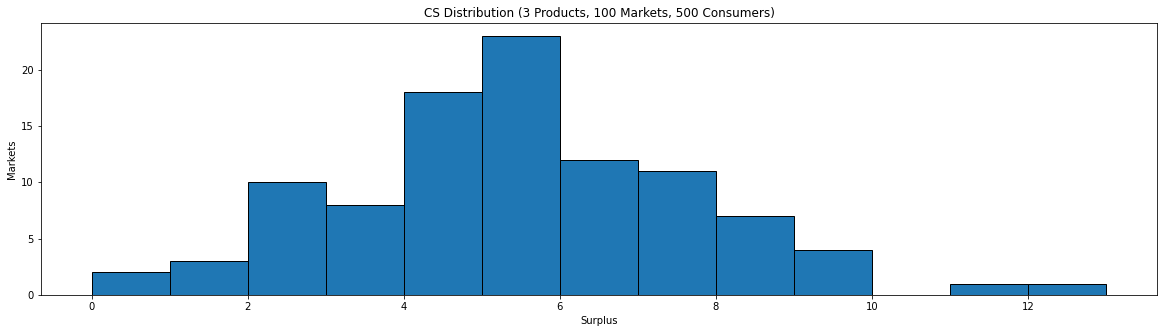

In [452]:
plot_estimated_cs(100, 3, 1.25)

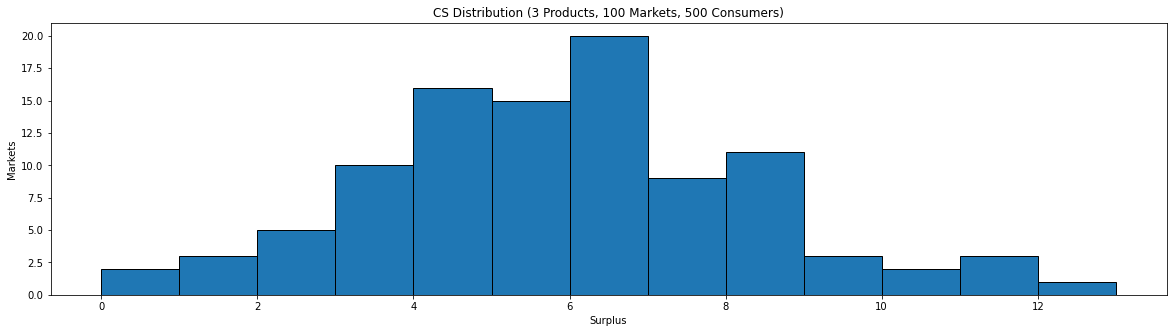

In [443]:
plot_cs(100, 3)

2a. We can here use our elasticity formulations. If there is perfect competition, we know that $MC = P$ and we can just use the prices as marginal costs.

If this is oligopoly, and each firm is only pricing for their one product, we will have $\Delta$ given by

$$\Delta = \begin{bmatrix}
-\frac{\partial s_{11}}{\partial p_{11}} & 0 & 0 & ... & 0 \\
0 & -\frac{\partial s_{12}}{\partial p_{12}} & 0 & ... & 0 \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & ... & -\frac{\partial s_{(m-1)(j-1)}}{\partial p_{(m-1)(j-1)}} & 0 \\
0 & 0 & 0 & ... & -\frac{\partial s_{mj}}{\partial p_{mj}}
\end{bmatrix}$$

which yields $MC = P - \Delta^{-1}s$

Under perfect collusion, all firms care about the impact of price changes on the shares of other products in their market:
$$\Delta = \begin{bmatrix}
-\frac{\partial s_{11}}{\partial p_{11}} & -\frac{\partial s_{12}}{\partial p_{11}} & -\frac{\partial s_{13}}{\partial p_{11}} & ... & -\frac{\partial s_{1j}}{\partial p_{11}} & 0 & 0 & ... & 0 \\
-\frac{\partial s_{11}}{\partial p_{12}} & -\frac{\partial s_{12}}{\partial p_{12}} & -\frac{\partial s_{13}}{\partial p_{12}} & ... & -\frac{\partial s_{1j}}{\partial p_{12}} & 0 & 0 & ... & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & ... & 0 & ... & -\frac{\partial s_{m(j-2)}}{\partial p_{mj}} & -\frac{\partial s_{m(j-1)}}{\partial p_{mj}} & -\frac{\partial s_{mj}}{\partial p_{mj}}
\end{bmatrix}$$

which yields $MC = P - \Delta^{-1}s$
<!-- We then calculate $\Delta$. As firms produce one good per market, $\Delta$ will be diagonal, with elements given by
$$-\frac{\partial s_j}{\partial p_j}$$
For an individual $i$, the choice probability of choosing product $j$ is given by
$$\mathbb{P}_{ij} = \frac{\exp(\delta_j - p_j \nu_i \sigma_{\alpha})}{1 + \sum_{k=1}^J\exp(\delta_k - p_k \nu_i \sigma_{\alpha})}$$
This means that
$$\frac{\partial \mathbb{P}_{ij}}{\partial p_j} = \frac{\left(1 + \sum_{k=1}^J\exp(\delta_k - p_k \nu_i \sigma_{\alpha})\right)\exp(\delta_j - p_j \nu_i \sigma_{\alpha})(-\alpha - \sigma_{\alpha}\nu_i) - \exp(\delta_j - p_j \nu_i \sigma_{\alpha})^2(-\alpha - \sigma_{\alpha}\nu_i)}{\left(1 + \sum_{k=1}^J\exp(\delta_k - p_k \nu_i \sigma_{\alpha})\right)^2}$$
and
$$-\frac{\partial s_j}{\partial p_j} = -\frac{1}{n}\sum_{i=1}^{ns}\frac{\partial \mathbb{P}_{ij}}{\partial p_j}$$
Given our shares formulation, we have
$$-\frac{\partial s_j}{\partial p_j} = -\frac{1}{n}\sum_{i=1}^{500}\frac{(1+\sum_s{\exp(\delta_s + \mu_{is})})(-\alpha-\sigma_{\alpha}\nu_i)\exp(\delta_j + \mu_{ij}) + (\alpha + \sigma_{\alpha}\nu_i)(\exp(\delta_j + \mu_{ij}))^2}{(1+\sum_s{\exp(\delta_s + \mu_{is})})^2}$$
Simplifying yields
$$\frac{\partial s_j}{\partial p_j} = \frac{1}{n}\sum_{i=1}^{500}(\alpha + \sigma_{\alpha}\nu_i)(s_{ij}^2 - s_{ij})$$
and
$$\frac{\partial s_j}{\partial p_k} = \frac{1}{n}\sum_{i=1}^{500}(\alpha + \sigma_{\alpha}\nu_i)(s_{ij}s_{ik})$$ -->

In [499]:
def get_markup(mkts,prods,n_consumers,sigma,alpha,price_vals,nu_i_vals,comp_type):
    if comp_type == 'perfect':
        return(np.zeros(mkts * prods).reshape(-1,1))
    elif comp_type == 'oligopoly':
        elas = get_elasticities(100,3,500,1.,1.,P_opt,alphas.reshape(-1,1)-1.)
        Delta = -1 * sp.linalg.block_diag(*[elas[(i*prods):((i+1) * prods)] for i in range(mkts)]) * np.eye(300)
        s_hat = get_shares(100,3,500,P_opt.T,get_delta(1.,alphas.reshape(-1,1)-1.),1.,alphas.reshape(-1,1)-1.)
        markup = np.linalg.inv(Delta) @ s_hat.reshape(-1,1)
        return(markup)
    elif comp_type == 'collusion':
        elas = get_elasticities(100,3,500,1.,1.,P_opt,alphas.reshape(-1,1)-1.)
        Delta = -1 * sp.linalg.block_diag(*[elas[(i*prods):((i+1) * prods)] for i in range(mkts)])
        s_hat = get_shares(100,3,500,P_opt.T,get_delta(1.,alphas.reshape(-1,1)-1.),1.,alphas.reshape(-1,1)-1.)
        markup = np.linalg.inv(Delta) @ s_hat.reshape(-1,1)
        return(markup)

In [500]:
# import data
x1,xi_all,w,eta,Z,alphas,P_opt,shares = import_data(mkts,prods)

mc_true = (np.column_stack([np.ones(prods * mkts),w, Z]) @ gamma + eta).reshape(100,3)

mc_perf_comp = P_opt.T - get_markup(100,3,500,1.,1.,P_opt,alphas.reshape(-1,1)-1., 'perfect').reshape(mkts, prods)
mc_olig = P_opt.T - get_markup(100,3,500,1.,1.,P_opt,alphas.reshape(-1,1)-1., 'oligopoly').reshape(mkts, prods)
mc_collusion = P_opt.T - get_markup(100,3,500,1.,1.,P_opt,alphas.reshape(-1,1)-1., 'collusion').reshape(mkts, prods)

In [501]:
pd.DataFrame(data = {'mc_true': mc_true.reshape(-1),
                     'mc_perf_comp': mc_perf_comp.reshape(-1),
                     'mc_olig': mc_olig.reshape(-1),
                     'mc_collusion': mc_collusion.reshape(-1)}).describe()

,mc_true,mc_perf_comp,mc_olig,mc_collusion
count,300.000000,300.000000,300.000000,300.000000
mean,2.051214,3.026549,2.825875,1.874335
std,1.577606,1.371157,1.648588,7.971247
min,-2.259204,0.163102,-6.223062,-95.240258
25%,0.847252,1.988151,1.829541,1.390512
50%,2.047371,2.827857,2.797871,2.666966
75%,3.181108,3.963675,3.947232,3.847671
max,6.283119,7.028482,7.028430,7.028087


To compute all the parameters under these assumptions, we need to get the values of $\hat{\omega}$ by using the pricing assumption, and then feed that into the new GMM criterion function. Thus, we need to add code to get the $\hat{\omega}$ values, and adjust the GMM criterion.

In [502]:
def calculate_gamma(P,markup_vals,w_val,Z):
    # get the marginal cost
    mc = P.T - markup_vals
    
    # projection matrix
    P_Z = Z @ np.linalg.inv(Z.T @ Z) @ Z.T
    
    return(np.linalg.inv(w_val.T @ P_Z @ w_val) @ w_val.T @ P_Z @ mc.reshape(-1,1))

In [ ]:
def calculate_omega_hat(P,markup_vals,w_val,Z):
    # get the marginal cost
    mc = P.T - markup_vals
    # get the gamma hat
    gamma_hat = calculate_gamma(P,markup_vals,w_val,Z)
    
    return(mc.reshape(-1,1) - w_val @ gamma_hat)

In [ ]:
def gmm_supply_obj(sigma, Z, nu_i_val):
    
    delta_new = get_delta(sigma,nu_i_val)
    
    theta1 = calculate_theta1(delta_new,x1,P_opt,Z)

    xi_hat = get_xi_hat(delta_new,x1,P_opt,Z)
    W = np.linalg.inv(Z.T @ Z)
    return((xi_hat.T @ Z @ W @ Z.T @ xi_hat).item())

In [509]:
import autograd.numpy as np
from autograd import grad, jacobian

def gmm_obj(sigma):
    
    delta_new = get_delta(sigma,nu_i_fixed)
    
    theta1 = calculate_theta1(delta_new,x1,P_opt,demand_Z)

    xi_hat = get_xi_hat(delta_new,x1,P_opt,demand_Z)
    W = ag_np.linalg.inv(Z.T @ Z)
    return((xi_hat.T @ Z @ W @ Z.T @ xi_hat).item())

grad_val = grad(gmm_obj)
grad_val(ag_np(1., dtype = 'float'))

TypeError: 'module' object is not callable

In [508]:
x = ag_np.array([5,3], dtype=float)

def cost(x):
    return x[0]**2 / x[1] - ag_np.log(x[1])

gradient_cost = grad(cost)
jacobian_cost = jacobian(cost)

gradient_cost(x)
#jacobian_cost(np.array([x,x,x]))

array([ 3.33333333, -3.11111111])